In [1]:
import os
import sys
import glob

import librosa
import librosa.display

sys.path.append(os.path.dirname(os.path.abspath(f'{os.getcwd()}/AudioCLIP/audioclip')))
from AudioCLIP.audioclip.model import AudioCLIP

import numpy as np

import torch

import matplotlib.pyplot as plt

from PIL import Image
from IPython.display import Audio, display

sys.path.append(os.path.abspath(f'{os.getcwd()}'))

from AudioCLIP.audioclip.model import AudioCLIP
from AudioCLIP.audioclip.utils.transforms import ToTensor1D


torch.set_grad_enabled(False)

MODEL_FILENAME = 'AudioCLIP-Full-Training.pt'
# derived from ESResNeXt
SAMPLE_RATE = 44100
# derived from CLIP
IMAGE_SIZE = 224
IMAGE_MEAN = 0.48145466, 0.4578275, 0.40821073
IMAGE_STD = 0.26862954, 0.26130258, 0.27577711

LABELS = ['cat', 'thunderstorm', 'coughing', 'alarm clock', 'car horn']

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/karolwojtulewicz/miniconda3/envs/aformer/lib/python3.10/site-packages/lazy_loader/__init__.py:185: RuntimeWarning: subpackages can technically be lazily loaded, but it causes the package to be eagerly loaded even if it is already lazily loaded.So, you probably shouldn't use subpackages with this lazy feature.
  warnings.warn(msg, RuntimeWarning)
/home/karolwojtulewicz/miniconda3/envs/aformer/lib/python3.10/site-packages/lazy_loader/__init__.py:185: RuntimeWarning: subpackages can technically be lazily loaded, but it causes the package to be eagerly loaded even if it is already lazily loaded.So, you probably shouldn't use subpackages with this lazy feature.
  warnings.warn(msg, RuntimeWarning)
/home/karolwojtulewicz/miniconda3/envs/aformer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
aclp = AudioCLIP(pretrained=f'./pretrained/AudioCLIP/{MODEL_FILENAME}').to(device)

In [3]:
audio_transforms = ToTensor1D()

In [4]:
paths_to_audio = glob.glob('data/thumos/i3d_features/*.wav')[:5]

audio = list()
for path_to_audio in paths_to_audio:
    print("Processing audio: {}".format(path_to_audio))
    track, _ = librosa.load(path_to_audio, sr=SAMPLE_RATE, dtype=np.float32)

    # compute spectrograms using trained audio-head (fbsp-layer of ESResNeXt)
    # thus, the actual time-frequency representation will be visualized
    spec = aclp.audio.spectrogram(torch.from_numpy(track.reshape(1, 1, -1)).to(device))
    spec = np.ascontiguousarray(spec.cpu().numpy()).view(np.complex64)
    pow_spec = 10 * np.log10(np.abs(spec) ** 2 + 1e-18).squeeze()

    audio.append((track, pow_spec))

Processing audio: data/thumos/i3d_features/video_validation_0000721.wav
Processing audio: data/thumos/i3d_features/video_validation_0000332.wav
Processing audio: data/thumos/i3d_features/video_validation_0000317.wav
Processing audio: data/thumos/i3d_features/video_test_0001402.wav
Processing audio: data/thumos/i3d_features/video_validation_0000912.wav


In [5]:
def show_data():
    fig, axes = plt.subplots(2, len(audio), figsize=(20, 5), dpi=100)

    for idx in range(len(audio)):
        print(f'Processing {idx + 1}/{len(audio)}')
        track, pow_spec = audio[idx]

        # draw the waveform
        librosa.display.waveshow(track, sr=SAMPLE_RATE, ax=axes[0, idx], color='k')
        # show the corresponding power spectrogram
        axes[1, idx].imshow(pow_spec, origin='lower', aspect='auto', cmap='gray', vmin=-180.0, vmax=20.0)

        # modify legend
        axes[0, idx].set_title(os.path.basename(paths_to_audio[idx]))
        axes[0, idx].set_xlabel('')
        axes[0, idx].set_xticklabels([])
        axes[0, idx].grid(True)
        axes[0, idx].set_ylim(bottom=-1, top=1)

        axes[1, idx].set_xlabel('Time (s)')
        axes[1, idx].set_xticks(np.linspace(0, pow_spec.shape[1], len(axes[0, idx].get_xticks())))
        axes[1, idx].set_xticklabels([f'{tick:.1f}' if tick == int(tick) else '' for tick in axes[0, idx].get_xticks()])
        axes[1, idx].set_yticks(np.linspace(0, pow_spec.shape[0] - 1, 5))

    axes[0, 0].set_ylabel('Amplitude')
    axes[1, 0].set_ylabel('Filter ID')

    plt.show()
    plt.close(fig)

    for idx, path in enumerate(paths_to_audio):
        print(os.path.basename(path))
        display(Audio(audio[idx][0], rate=SAMPLE_RATE, embed=True))
# show_data()

torch.Size([1, 2048, 6281])


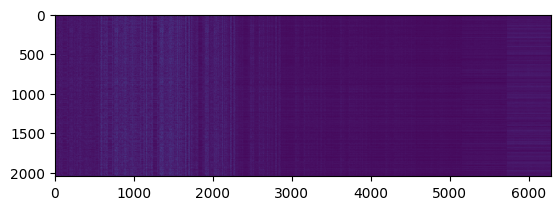

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [29]:
# AudioCLIP handles raw audio on input, so the input shape is [batch x channels x duration]
index = 0
for index in range(1):
    audio_ = torch.stack([audio_transforms(track.reshape(1, -1)) for track, _ in audio[index:index + 1]])
    ((audio_features, _, _), _), _ = aclp(audio=audio_, only_embedding=True, flatten=True)
    print(audio_features.shape)
plt.imshow(audio_features.detach().cpu().squeeze().numpy())
plt.show()